#Imports

In [1]:
!pip install python-telegram-bot

     |████████████████████████████████| 430kB 14.2MB/s 
     |████████████████████████████████| 2.6MB 47.9MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 


In [2]:
#==================================================================
# to NST_net
#==================================================================
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms
from torchvision.models import vgg19
import requests
from IPython.display import clear_output
%matplotlib inline

#==================================================================
# to bot
#==================================================================
from telegram import Update
from telegram import KeyboardButton
from telegram import ReplyKeyboardMarkup
from telegram.ext import Updater
from telegram.ext import CallbackContext
from telegram.ext import Filters # гибкая логика ответа на сообщения
from telegram.ext import MessageHandler

#NST_net

In [3]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
backbone = vgg19(pretrained=True).features.to(device).eval().requires_grad_(False)

for (i, layer) in enumerate(backbone):
  if isinstance(layer, torch.nn.MaxPool2d):
    backbone[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [5]:
def load_image(url_img, max_size=256, shape=None):
    
    image = requests.get(url_img).content
    with open('/content/image_name.jpg', 'wb') as handler:
        handler.write(image)
    image = Image.open('/content/image_name.jpg').convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [6]:
# convert tesnor to image, denormalize
def im_convert(tensor):
  # tensor.detach() creates a tensor that shares storage with tensor that does not require grad. 
  # It detaches the output from the computational graph. So no gradient will be backpropagated along this variable.
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0) # to -> H, W, C
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
  image = image.clip(0, 1)
  return image

In [7]:
# content im.
content = load_image('https://w-dog.ru/wallpapers/2/2/549185023775360/yug-germanii-yugo-zapadnaya-bavariya-zamok-nojshvanshtajn-osen-gory.jpg').to(device)
# styles im., resize style to content
style_1 = load_image('https://img2.goodfon.ru/original/1920x1408/0/aa/kartina-zvezdnaya-noch-van-goga.jpg',
                     shape=content.shape[-2:]).to(device)
#'https://telegra.ph/file/cb442889243e5e96cb73f.jpg'
style_2 = load_image('https://i.pinimg.com/originals/b9/90/a2/b990a2d645291b40577a7315683b61df.png',
                     shape=content.shape[-2:]).to(device)

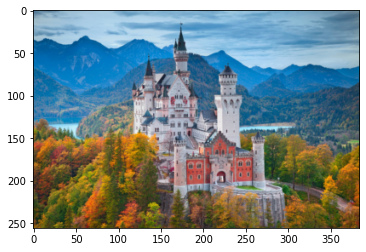

In [8]:
plt.imshow(im_convert(content))

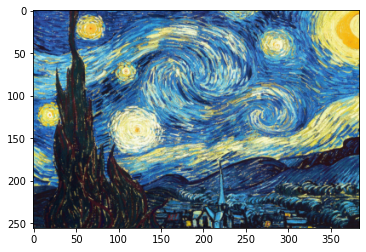

In [9]:
plt.imshow(im_convert(style_1))

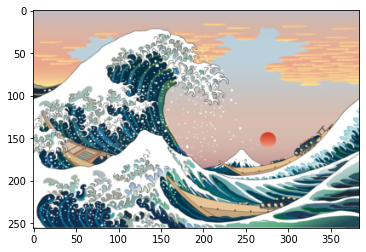

In [10]:
plt.imshow(im_convert(style_2))

#Net building and Training

In [11]:
def gram_matrix(tensor):
    batch_size, channels, height, width = tensor.size()
    
    tensor = tensor.view(batch_size * channels, height * width)
    gram = tensor @ tensor.t()
    
    return gram

def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # content layer
                  '28': 'conv5_1'}
    features = {}
    x = image
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [16]:
def NST_fit(content, style, backbone, num_epochs=3000):

  # get_content features
  content_features = get_features(content, backbone)
  # grad for content
  target = content.clone().requires_grad_(True).to(device)

  # get_style features
  style_features = get_features(style, backbone)
  # gram matrix for all in style_features
  style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

  # learn pams/optim
  optimizer = optim.AdamW([target], lr=3e-3)

  style_weights = {'conv1_1': 0.1,
                  'conv2_1': 0.2,
                  'conv3_1': 0.2,
                  'conv4_1': 0.5,
                  'conv5_1': 0.75}
  content_weight = 1 
  style_weight = 1e5
  
  # train loop
  for ii in range(1, num_epochs+1):

      # refresh target_features
      target_features = get_features(target, backbone)
      # refresh_content_loss
      content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
      # init style_loss
      style_loss = 0

      for layer in style_weights:
          # get the "target" style representation for the layer
          target_feature = target_features[layer]

          _, d, h, w = target_feature.shape
          
          # get the "target" gram matrix
          target_gram = gram_matrix(target_feature)
          # get the "style" style representation
          style_gram = style_grams[layer]

          # the style loss for one layer, weighted appropriately
          layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
          # add to the style loss
          style_loss += layer_style_loss / (d * h * w)

      total_loss = content_weight * content_loss + style_weight * style_loss 
      
      # update your target image
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

  return target

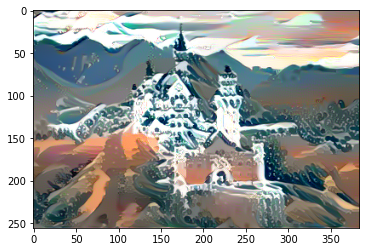

In [18]:
target = NST_fit(content, style_2, backbone)
plt.imshow(im_convert(target))

#Bot coding

In [11]:
# Имя кнопки
button_help = 'Помощь'


def massage_handler(update: Update, context: CallbackContext):

  reply_

  update.message.reply_text(
      text='Привет'
  )

def main():

  print('Start')

  updater = Updater(
      token='1663109481:AAEAu9pghz8DNRcUdT64s5O4tGmaEMq0H0s',
      use_context=True
  )

  updater.dispatcher.add_handler(MessageHandler(
      filters=Filters.all, callback=massage_handler # Fillters.all
      ))

  updater.start_polling()
  updater.idle() # выключается только руками, иначе один раз выполняется и все
  

In [12]:
if __name__ == '__main__':
  main()

Start
